# Notebook with various expirement with XGBoost

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report, roc_auc_score, roc_curve, mean_absolute_error
from IPython.display import display
import random
import shap

from util import make_study_df, \
    plot_shap_feature_importance, plot_xgb_feature_importance, plot_shap_importance_with_summary, \
    plot_shap_summary, plot_shap_heatmap, plot_shap_dependence, top_shap_values

In [4]:
! python --version

Python 3.11.5


In [5]:
print('xgboost version', xgb.__version__)
print('sklearn version', sklearn.__version__)
print('shap version', shap.__version__)

xgboost version 1.7.6
sklearn version 1.3.0
shap version 0.42.1


## load miRNA data

In [6]:
miRNA_df = pd.read_excel('../data/transposed_Tf_miRNA.xlsx')

## create dataframes and X, y datasets

In [7]:
df_all_weeks = make_study_df(miRNA_df)
df_8_weeks = make_study_df(miRNA_df, cohort_str='8_weeks')
df_16_weeks = make_study_df(miRNA_df, cohort_str='16_weeks')

In [8]:
X_all_weeks, y_all_weeks = df_all_weeks.drop('infected', axis=1), df_all_weeks['infected']
X_8_weeks, y_8_weeks = df_8_weeks.drop('infected', axis=1), df_8_weeks['infected']
X_16_weeks, y_16_weeks = df_16_weeks.drop('infected', axis=1), df_16_weeks['infected']

### compute XGBoost models

In [9]:
params = {
    "random_state": 42,
    "objective":"binary:logistic",
    "colsample_bytree": 0.3, 
    "learning_rate": 0.1,
}   

In [10]:
model_all_weeks = xgb.XGBClassifier(**params).fit(X_all_weeks, y_all_weeks)
model_8_weeks = xgb.XGBClassifier(**params).fit(X_8_weeks, y_8_weeks)
model_16_weeks = xgb.XGBClassifier(**params).fit(X_16_weeks, y_16_weeks)

### compute SHAP values (used for explainablity)

In [11]:
# need to change int and bool to classes int_ and bool_ to handle error 'numpy' has no attribute 'int'/'bool'/etc.
np.bool = np.bool_
np.int = np.int_
np.float = np.float_

In [12]:
explainer_all_weeks = shap.TreeExplainer(model_all_weeks, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_all_weeks = explainer_all_weeks(X_all_weeks)

explainer_8_weeks = shap.TreeExplainer(model_8_weeks, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_8_weeks = explainer_8_weeks(X_8_weeks)

explainer_16_weeks = shap.TreeExplainer(model_16_weeks, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_16_weeks = explainer_16_weeks(X_16_weeks)

## bar plots for feature importance

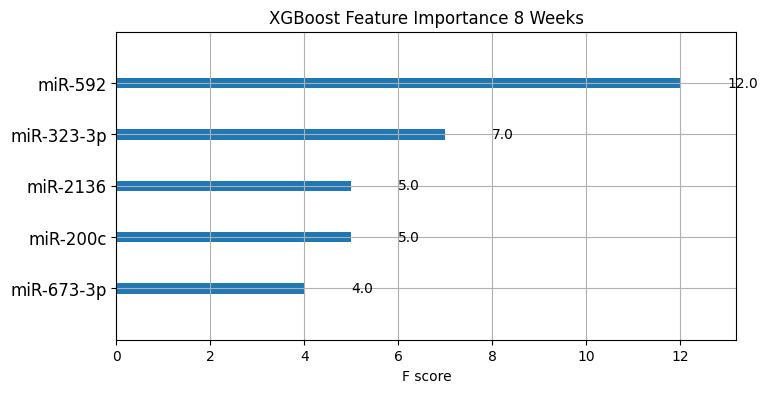

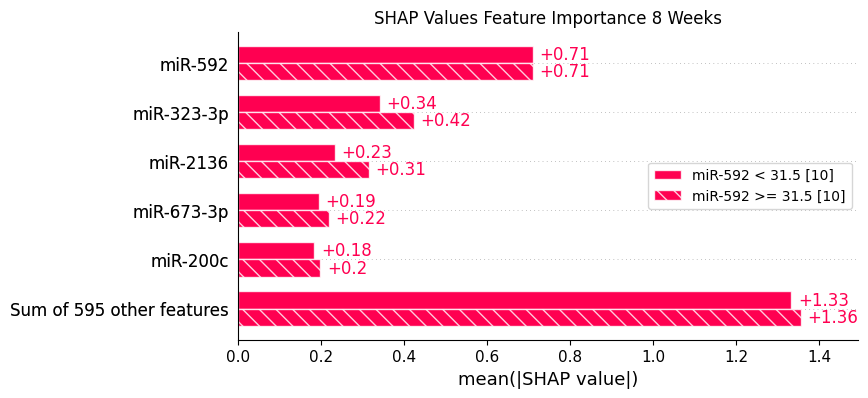

In [13]:
plot_xgb_feature_importance(
    model_8_weeks, 'XGBoost Feature Importance 8 Weeks', save_fig=False)
plot_shap_feature_importance(
    shap_values_8_weeks, 'SHAP Values Feature Importance 8 Weeks', save_fig=False)
# plot_shap_summary(
#     shap_values_8_weeks, X_8_weeks, 'SHAP Values Feature Importance 8 Weeks', plot_type='bar', save_fig=False)

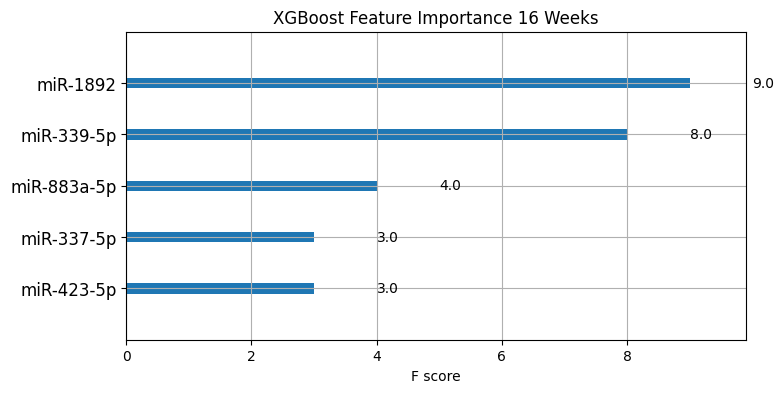

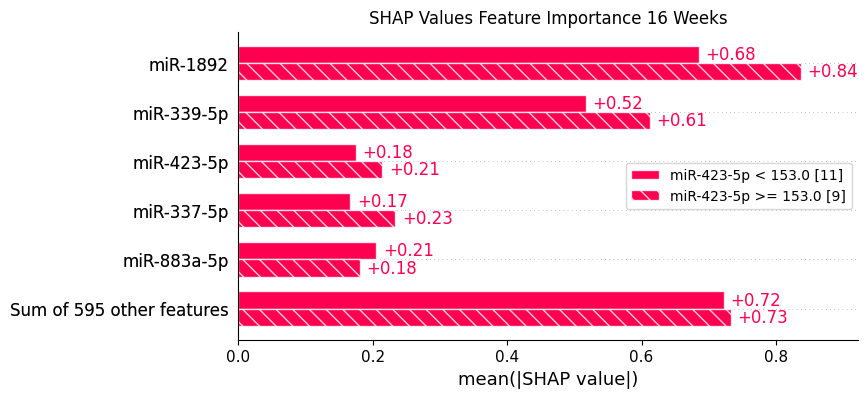

In [14]:
plot_xgb_feature_importance(
    model_16_weeks, 'XGBoost Feature Importance 16 Weeks', save_fig=False)
plot_shap_feature_importance(
    shap_values_16_weeks, 'SHAP Values Feature Importance 16 Weeks', save_fig=False)

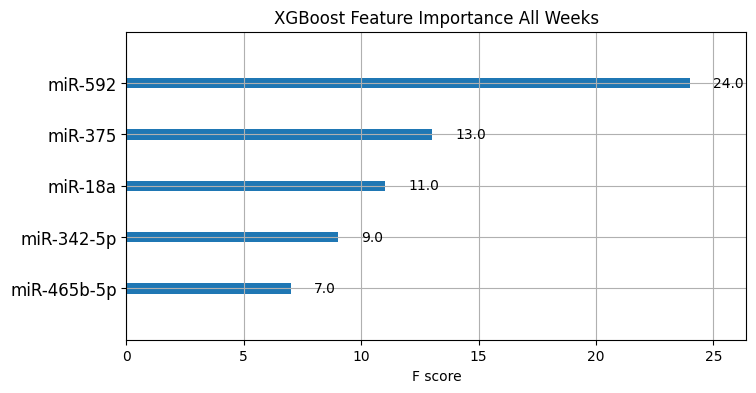

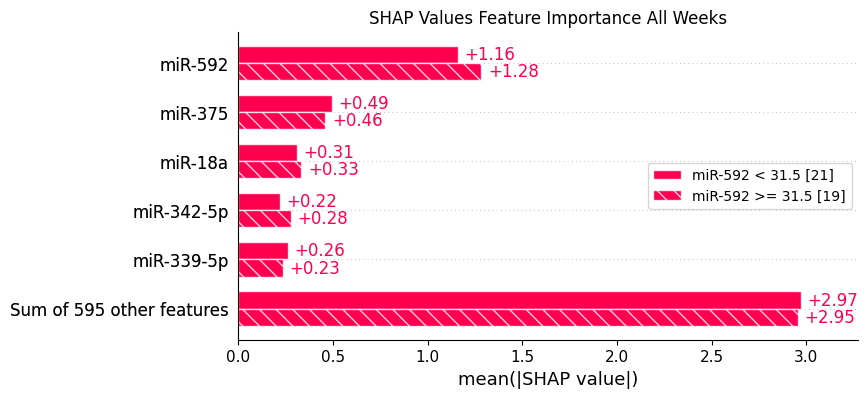

In [15]:
plot_xgb_feature_importance(
    model_all_weeks, 'XGBoost Feature Importance All Weeks', save_fig=False)
plot_shap_feature_importance(
    shap_values_all_weeks, 'SHAP Values Feature Importance All Weeks', save_fig=False)

## SHAP summary plots

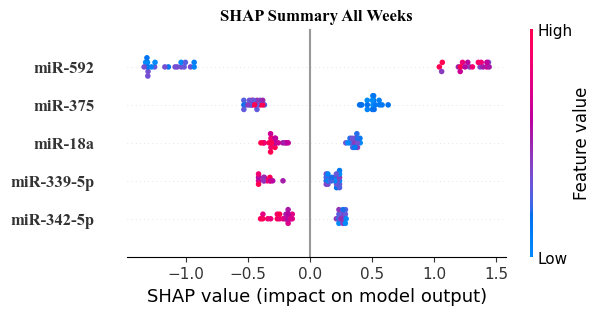

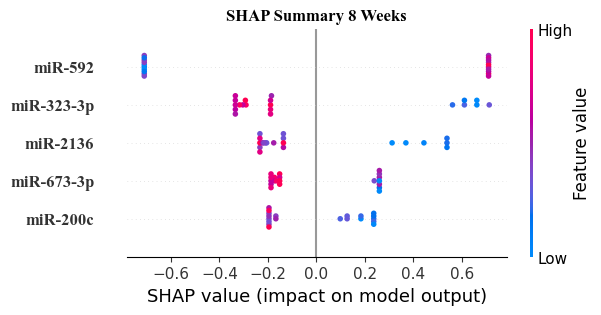

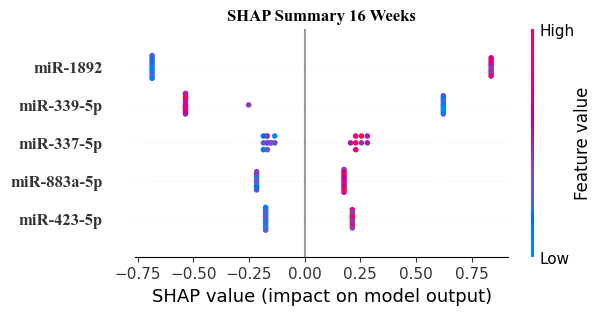

In [16]:
plot_shap_summary(shap_values_all_weeks, X_all_weeks, "SHAP Summary All Weeks", save_fig=False)
plot_shap_summary(shap_values_8_weeks, X_8_weeks, "SHAP Summary 8 Weeks", save_fig=False)
plot_shap_summary(shap_values_16_weeks, X_16_weeks, "SHAP Summary 16 Weeks", save_fig=False)

## SHAP heatmaps

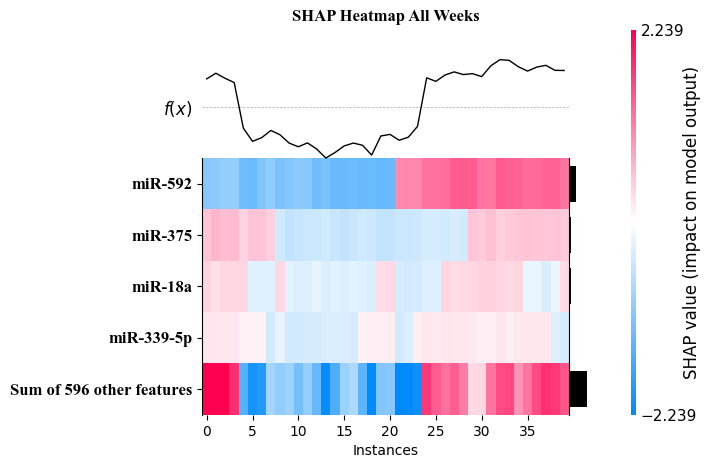

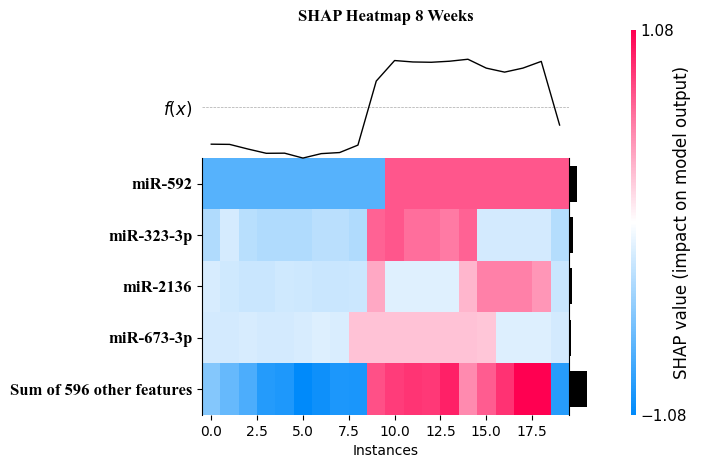

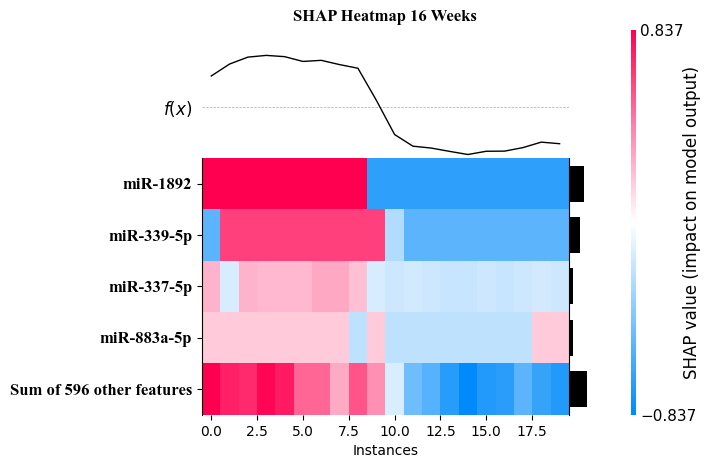

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
plot_shap_heatmap(shap_values_all_weeks, "SHAP Heatmap All Weeks", save_fig=False)
plot_shap_heatmap(shap_values_8_weeks, "SHAP Heatmap 8 Weeks", save_fig=False)
plot_shap_heatmap(shap_values_16_weeks, "SHAP Heatmap 16 Weeks", save_fig=False)

## SHAP dependence plots

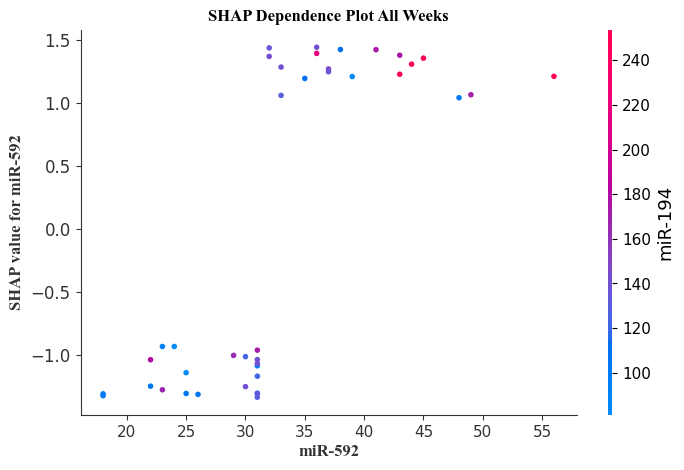

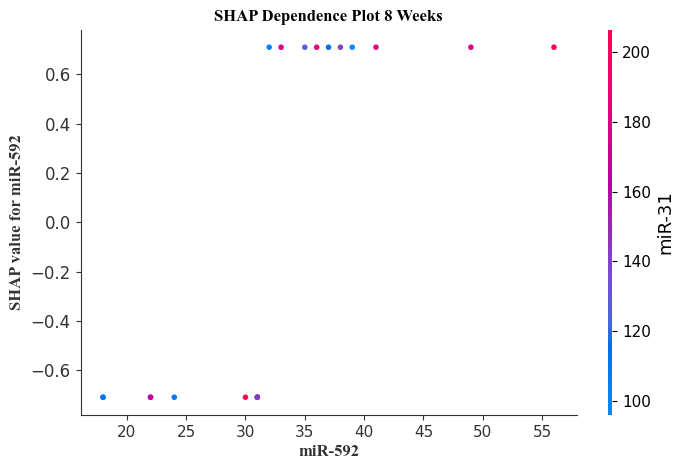

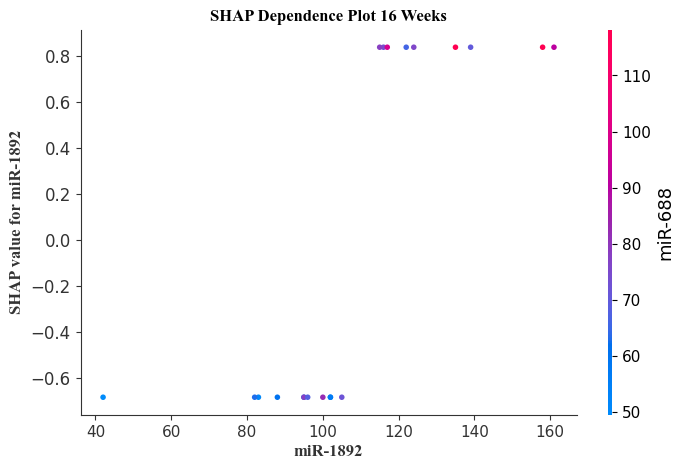

In [18]:
plot_shap_dependence(shap_values_all_weeks, X_all_weeks, "SHAP Dependence Plot All Weeks", save_fig=False)
plot_shap_dependence(shap_values_8_weeks, X_8_weeks, "SHAP Dependence Plot 8 Weeks", save_fig=False)
plot_shap_dependence(shap_values_16_weeks, X_16_weeks, "SHAP Dependence Plot 16 Weeks", save_fig=False)

---

## experiment with grid search for best params

In [23]:
cv_params = {
    'n_estimators': range(1,300),              # default = 100
    'max_depth': range(1, 100),                 # default = 3
    'learning_rate': [.1, .3, .4, .5, .6],     # default = .3
    'colsample_bytree': [.6, .7, .8, .9, 1],   # default = 1,
    'booster':['gbtree']
}

In [24]:
grid_search = GridSearchCV(xgb.XGBRegressor(), cv_params, n_jobs=10, scoring='neg_mean_absolute_error', refit=True)

In [25]:
# # this takes around 1 day to run, so saving the results
# grid_search.fit(X_8_weeks, y_8_weeks)
# grid_search.best_params_

# # results
# {'booster': 'gbtree',
#  'colsample_bytree': 0.7,
#  'learning_rate': 0.1,
#  'max_depth': 2,
#  'n_estimators': 1}

In [26]:
grid_params = {
    'booster': 'gbtree',
    'colsample_bytree': 0.7,
    'learning_rate': 0.1,
    'max_depth': 2,
    'n_estimators': 1
}
model_grid_all = xgb.XGBClassifier(**grid_params).fit(X_all_weeks, y_all_weeks)
model_grid_8 = xgb.XGBClassifier(**grid_params).fit(X_8_weeks, y_8_weeks)
model_grid_16 = xgb.XGBClassifier(**grid_params).fit(X_16_weeks, y_16_weeks)

In [27]:
explainer_grid_all = shap.TreeExplainer(model_grid_all, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_grid_all = explainer_grid_all(X_all_weeks)

explainer_grid_8 = shap.TreeExplainer(model_grid_8, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_grid_8 = explainer_grid_8(X_8_weeks)

explainer_grid_16 = shap.TreeExplainer(model_grid_16, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_grid_16 = explainer_grid_16(X_16_weeks)

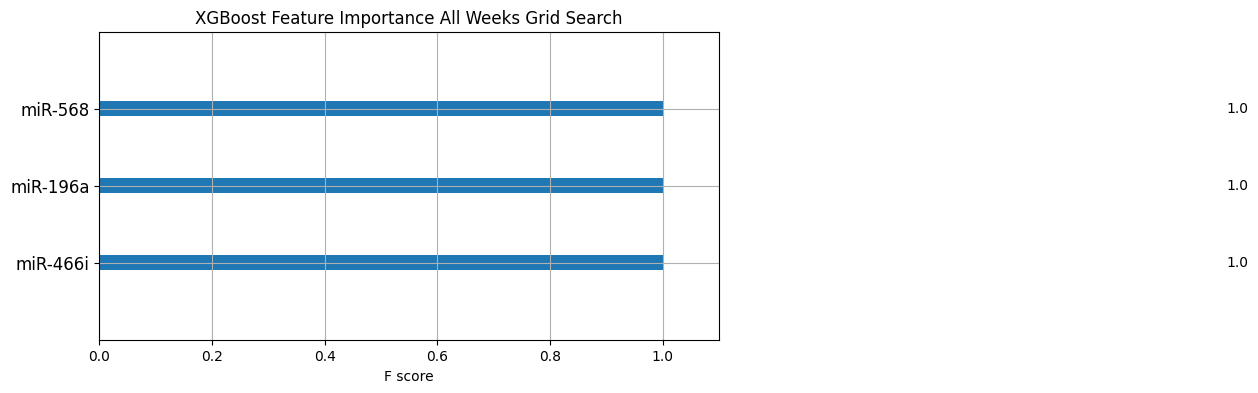

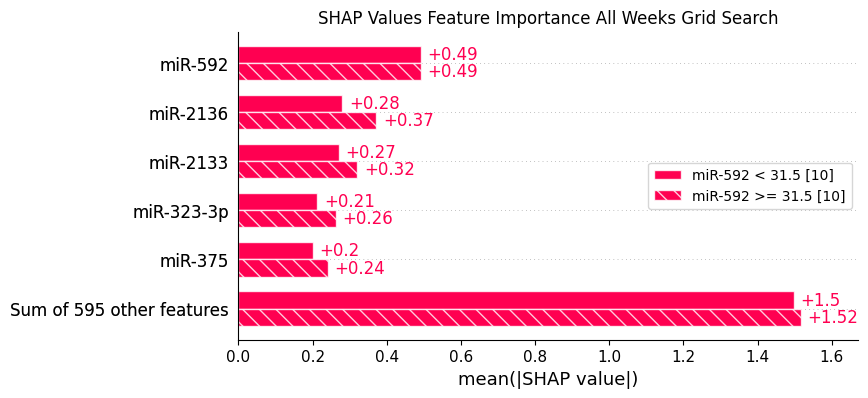

In [28]:
plot_xgb_feature_importance(model_grid_all, 'XGBoost Feature Importance All Weeks Grid Search', save_fig=False)
plot_shap_feature_importance(shap_values_8_weeks, 'SHAP Values Feature Importance All Weeks Grid Search', save_fig=False)

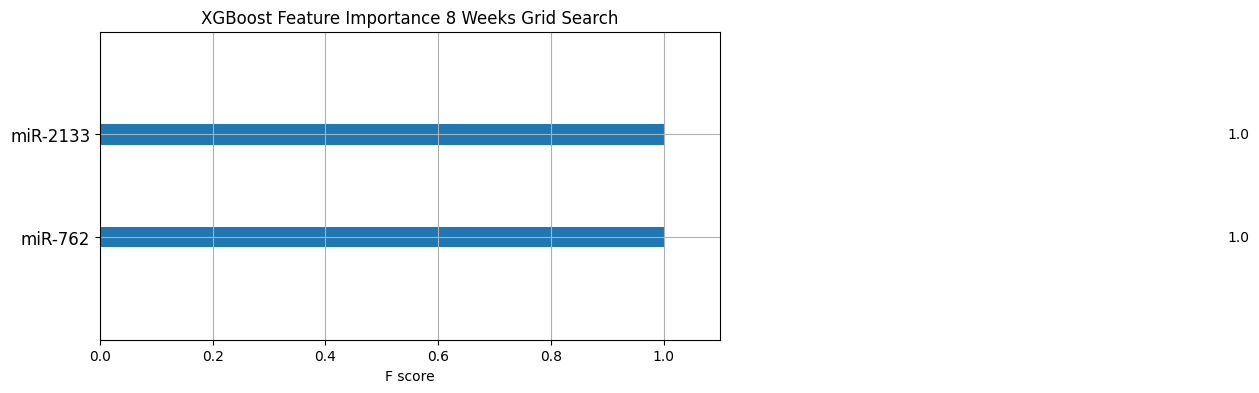

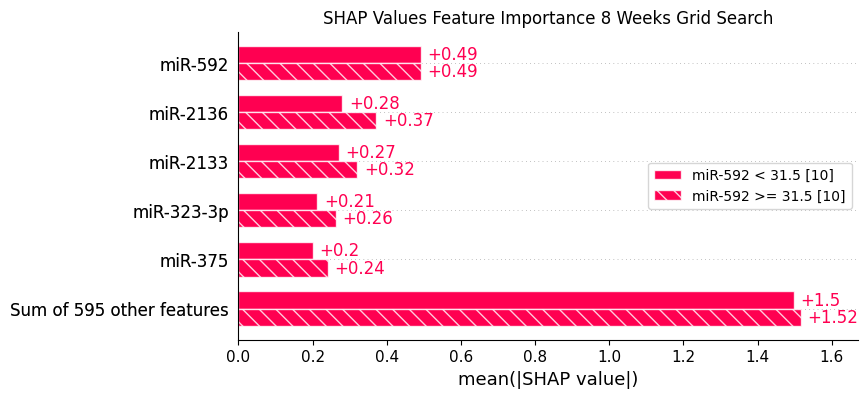

In [29]:
plot_xgb_feature_importance(model_grid_8, 'XGBoost Feature Importance 8 Weeks Grid Search', save_fig=False)
plot_shap_feature_importance(shap_values_8_weeks, 'SHAP Values Feature Importance 8 Weeks Grid Search', save_fig=False)

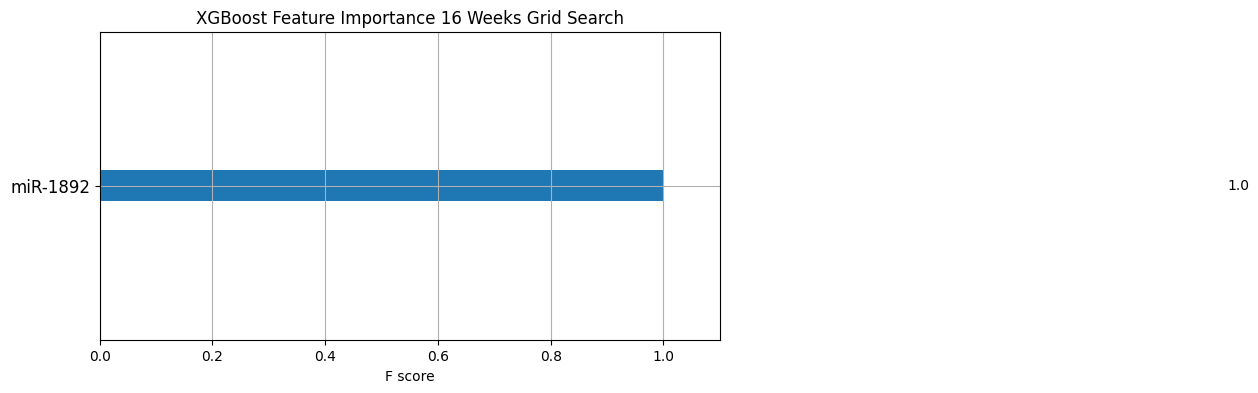

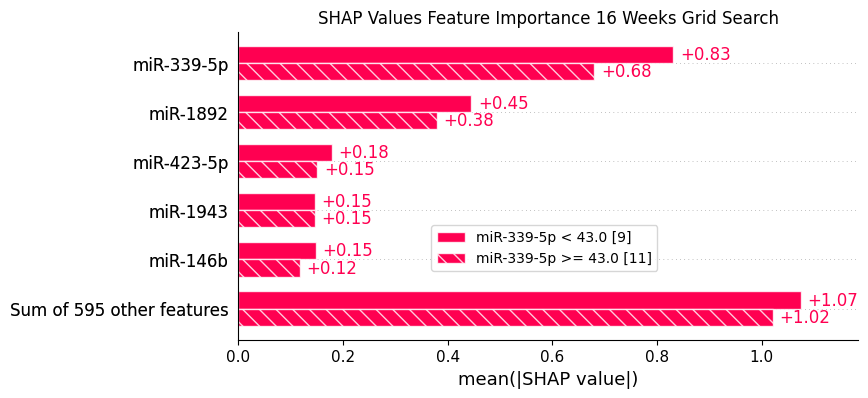

In [30]:
plot_xgb_feature_importance(model_grid_16, 'XGBoost Feature Importance 16 Weeks Grid Search', save_fig=False)
plot_shap_feature_importance(
    shap_values_16_weeks, 
    'SHAP Values Feature Importance 16 Weeks Grid Search',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2),
    save_fig=False
)

----

### expirment with increased extimators and tree depth

In [31]:
increased_params = {
    'booster': 'gbtree',
    'colsample_bytree': 0.7,
    'learning_rate': 0.1,
    'max_depth': 600,
    'n_estimators': 600,
    'random_state': 42
}
model_increased_all = xgb.XGBClassifier(**increased_params).fit(X_all_weeks, y_all_weeks)
model_increased_8 = xgb.XGBClassifier(**increased_params).fit(X_8_weeks, y_8_weeks)
model_increased_16 = xgb.XGBClassifier(**increased_params).fit(X_16_weeks, y_16_weeks)

In [32]:
explainer_increased_all = shap.TreeExplainer(model_increased_all, X_all_weeks, feature_names=X_all_weeks.columns.tolist())
shap_values_increased_all = explainer_increased_all(X_all_weeks)

explainer_increased_8 = shap.TreeExplainer(model_increased_8, X_8_weeks, feature_names=X_8_weeks.columns.tolist())
shap_values_increased_8 = explainer_increased_8(X_8_weeks)

explainer_increased_16 = shap.TreeExplainer(model_increased_16, X_16_weeks, feature_names=X_16_weeks.columns.tolist())
shap_values_increased_16 = explainer_increased_16(X_16_weeks)

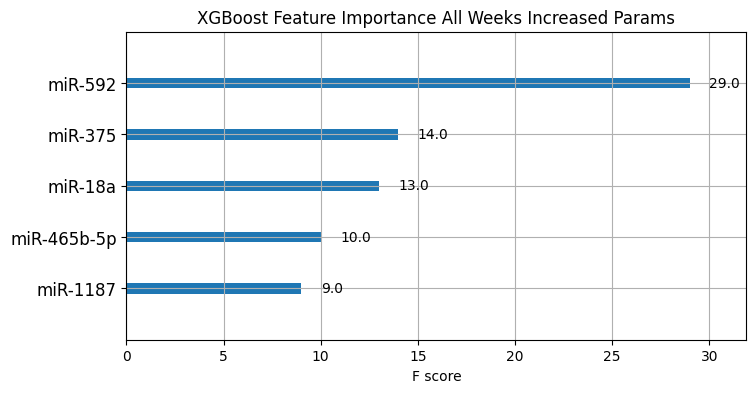

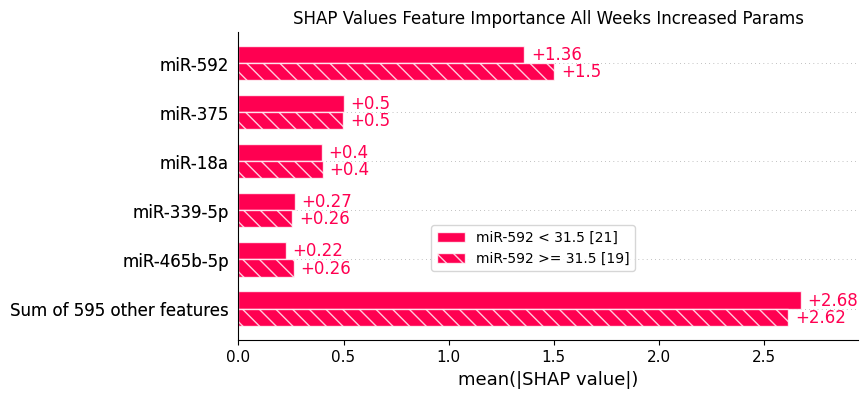

In [33]:
plot_xgb_feature_importance(model_increased_all, 'XGBoost Feature Importance All Weeks Increased Params', save_fig=False)
plot_shap_feature_importance(
    shap_values_increased_all, 
    'SHAP Values Feature Importance All Weeks Increased Params',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2),
    save_fig=False
)

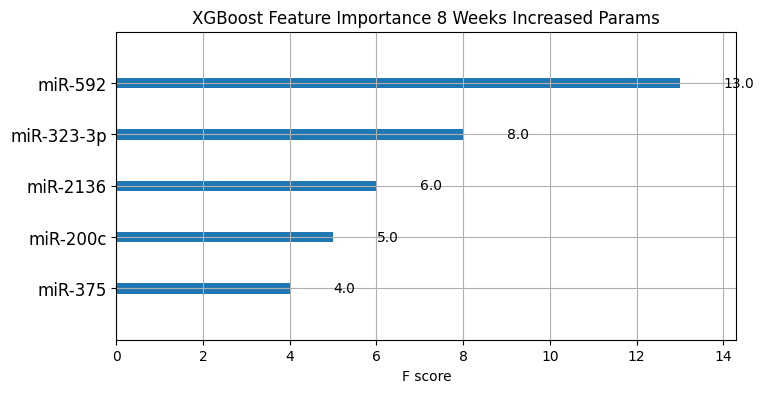

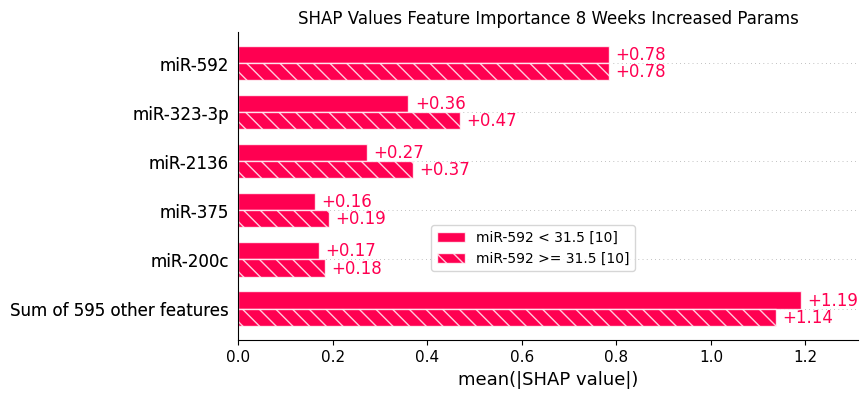

In [34]:
plot_xgb_feature_importance(model_increased_8, 'XGBoost Feature Importance 8 Weeks Increased Params', save_fig=False)
plot_shap_feature_importance(
    shap_values_increased_8, 
    'SHAP Values Feature Importance 8 Weeks Increased Params',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2),
    save_fig=False
)

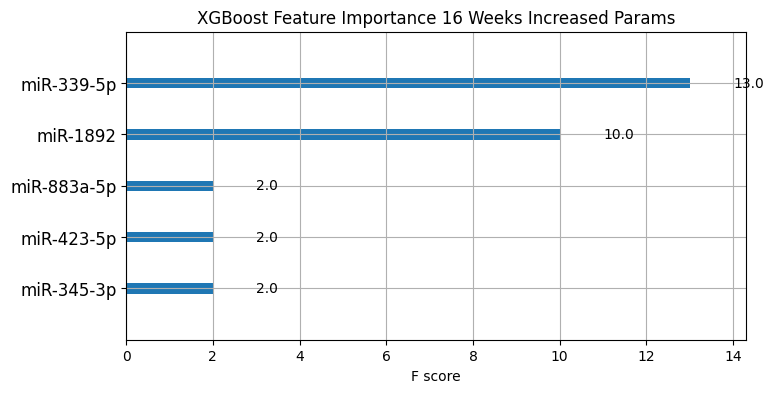

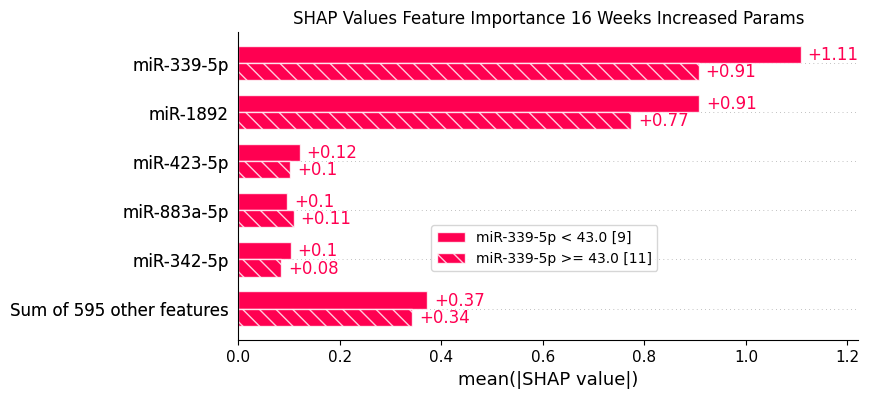

In [35]:
plot_xgb_feature_importance(model_increased_16, 'XGBoost Feature Importance 16 Weeks Increased Params', save_fig=False)
plot_shap_feature_importance(
    shap_values_increased_16, 
    'SHAP Values Feature Importance 16 Weeks Increased Params',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2),
    save_fig=False
)

---

## experiment with VIF

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [37]:
vif_df = pd.DataFrame()
vif_df["feature"] = X_8_weeks.columns
vif_df["VIF"] = [variance_inflation_factor(X_8_weeks.values, i) for i in range(len(X_8_weeks.columns))]

In [38]:
len(X_8_weeks.columns) == X_8_weeks.shape[1]

True

In [39]:
vif_df.head()

,feature,VIF
0,miR-142-3p,inf
1,miR-2132,inf
2,miR-664,inf
3,miR-762,inf
4,miR-698,inf


## expirement with recursive feature elemination

In [40]:
from sklearn.feature_selection import RFECV, RFE

In [41]:
params = {
    "random_state": 42,
    "objective":"binary:logistic",
    "colsample_bytree": 0.3, 
    "learning_rate": 0.1,
    #"nfold": 5,
    #"num_boost_round": 100, 
    #"early_stopping_rounds": 10, 
    #"metrics": "auc"
}   

In [42]:
selector_all = RFECV(xgb.XGBClassifier(**params), cv=5, min_features_to_select=100, scoring='accuracy')
selector_8 = RFECV(xgb.XGBClassifier(**params), cv=5, min_features_to_select=100, scoring='accuracy')
selector_16 = RFECV(xgb.XGBClassifier(**params), cv=5, min_features_to_select=100, scoring='accuracy')

In [43]:
selector_all = selector_all.fit(X_all_weeks, y_all_weeks)
selector_8 = selector_8.fit(X_8_weeks, y_8_weeks)
selector_16 = selector_16.fit(X_8_weeks, y_16_weeks)

In [44]:
selected_all_cols = list(selector_all.feature_names_in_[selector_all.support_])
X_all_selected = X_all_weeks[selected_all_cols]

selected_8_cols = list(selector_8.feature_names_in_[selector_8.support_])
X_8_selected = X_8_weeks[selected_8_cols]

selected_16_cols = list(selector_16.feature_names_in_[selector_16.support_])
X_16_selected = X_16_weeks[selected_16_cols]

In [45]:
model_selected_all = xgb.XGBClassifier(**params).fit(X_all_selected, y_all_weeks)
model_selected_8 = xgb.XGBClassifier(**params).fit(X_8_selected, y_8_weeks)
model_selected_16 = xgb.XGBClassifier(**params).fit(X_16_selected, y_16_weeks)

In [46]:
explainer_selected_all = shap.TreeExplainer(model_selected_all, X_all_selected, feature_names=X_all_selected.columns.tolist())
shap_values_selected_all = explainer_selected_all(X_all_selected)

explainer_selected_8 = shap.TreeExplainer(model_selected_8, X_8_selected, feature_names=X_8_selected.columns.tolist())
shap_values_selected_8 = explainer_selected_8(X_8_selected)

explainer_selected_16 = shap.TreeExplainer(model_selected_16, X_16_selected, feature_names=X_16_selected.columns.tolist())
shap_values_selected_16 = explainer_selected_16(X_16_selected)

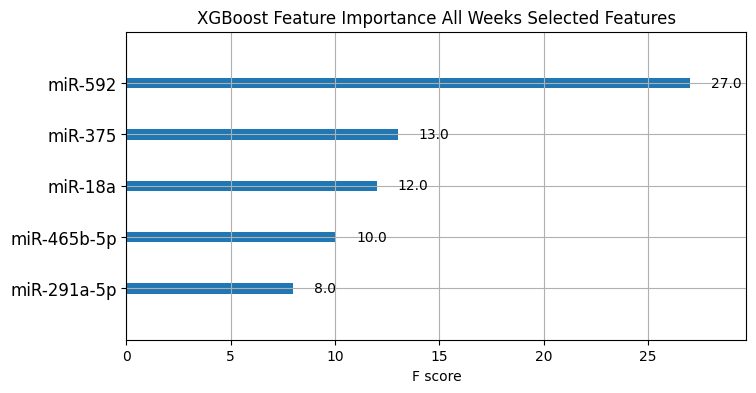

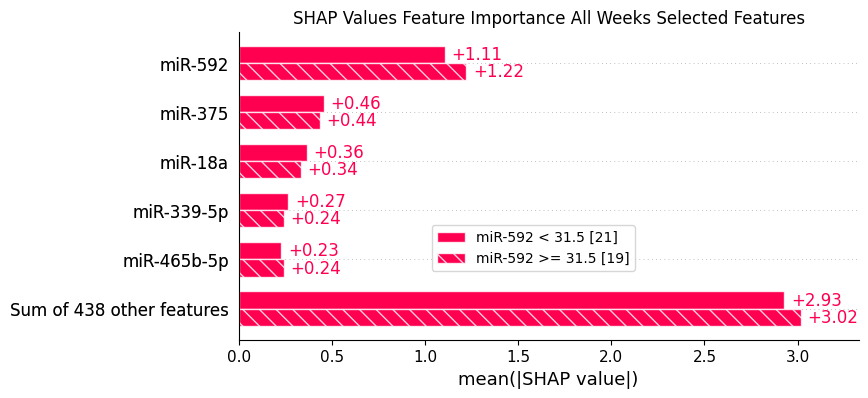

In [182]:
plot_xgb_feature_importance(model_selected_all, 'XGBoost Feature Importance All Weeks Selected Features', save_fig=False)
plot_shap_feature_importance(
    shap_values_selected_all, 
    'SHAP Values Feature Importance All Weeks Selected Features',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2),
    save_fig=False
)

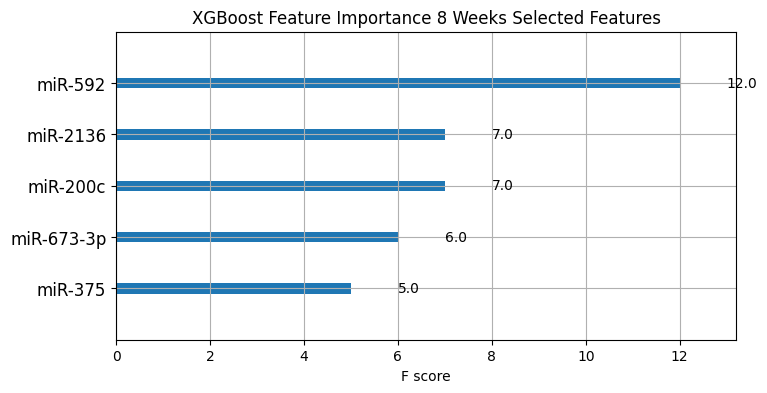

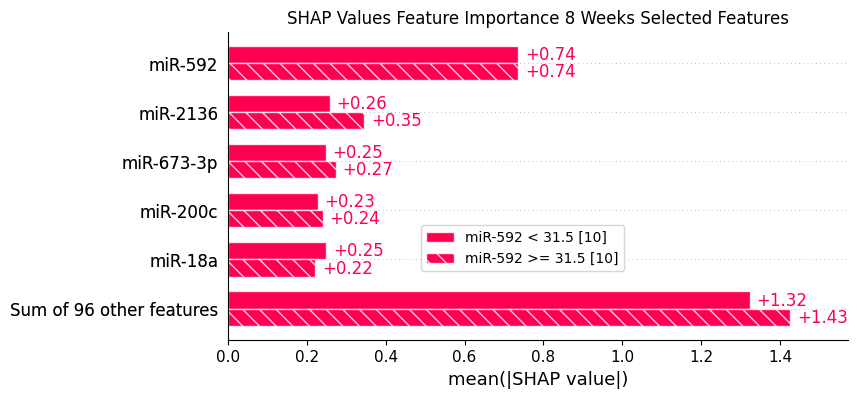

In [183]:
plot_xgb_feature_importance(model_selected_8, 'XGBoost Feature Importance 8 Weeks Selected Features', save_fig=False)
plot_shap_feature_importance(
    shap_values_selected_8, 
    'SHAP Values Feature Importance 8 Weeks Selected Features',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2),
    save_fig=False
)

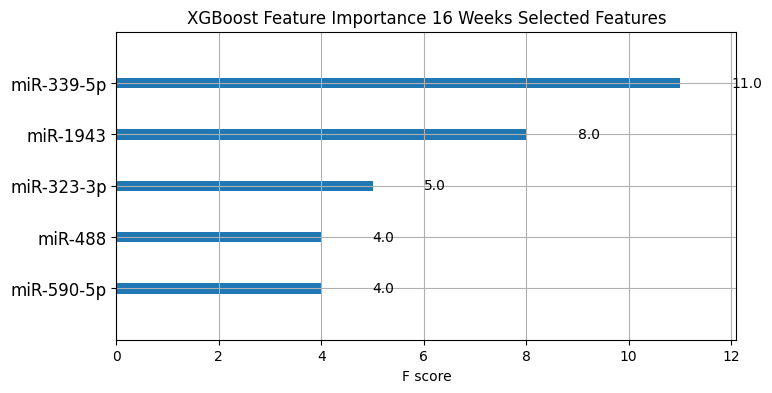

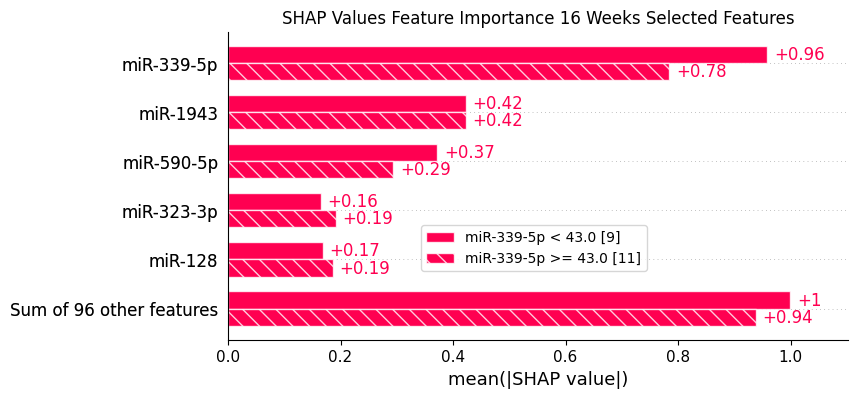

In [49]:
plot_xgb_feature_importance(model_selected_16, 'XGBoost Feature Importance 16 Weeks Selected Features', save_fig=False)
plot_shap_feature_importance(
    shap_values_selected_16, 
    'SHAP Values Feature Importance 16 Weeks Selected Features',
    legend_loc='lower left',
    bbox_values=(0.3, 0.2),
    save_fig=False
)

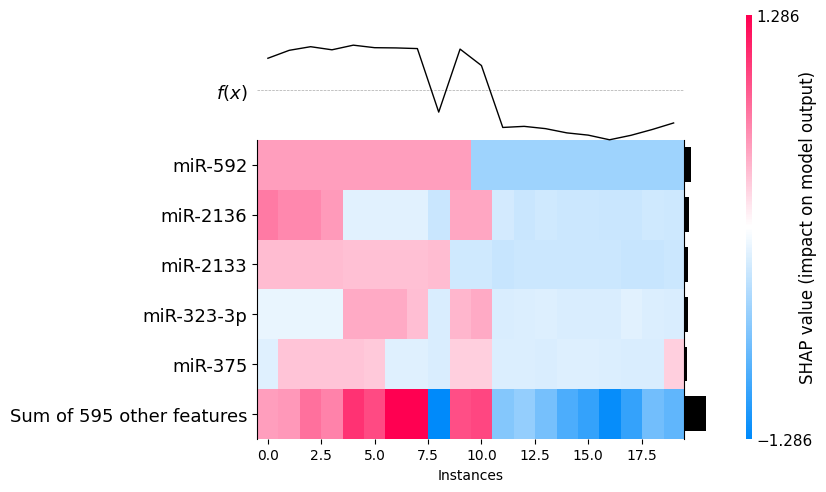

        feature  shap_val
61      miR-592  0.491753
563    miR-2136  0.326280
96     miR-2133  0.295496
446  miR-323-3p  0.237987
483     miR-375  0.220664


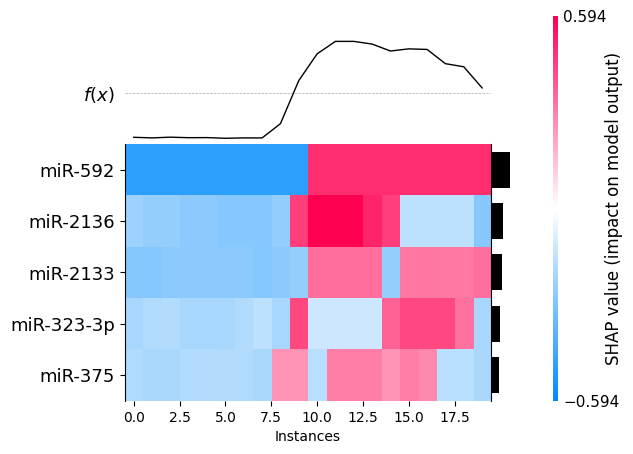

In [202]:
shap.plots.heatmap(shap_values_8_weeks, max_display=6)
shap.plots.heatmap(top_shap_values(shap_values_8_weeks, print_importance=True))

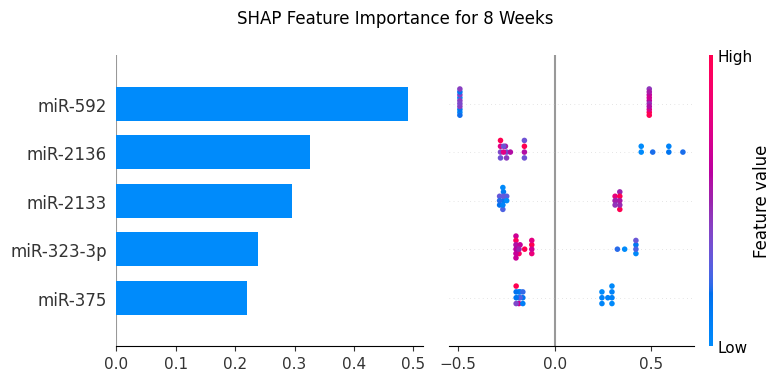

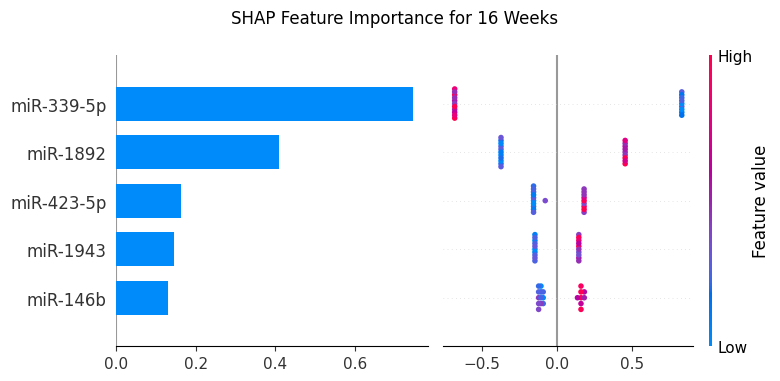

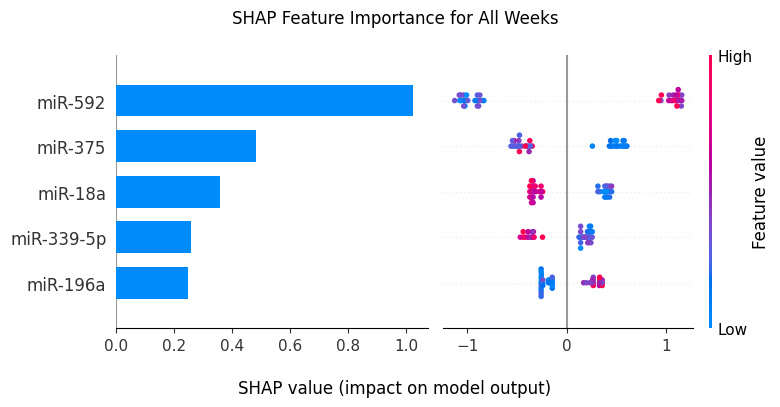

In [208]:
plot_shap_importance_with_summary(
    shap_values_8_weeks, 
    X_8_weeks, 
    title='SHAP Feature Importance for 8 Weeks',
    save_fig=False
)

plot_shap_importance_with_summary(
    shap_values_16_weeks, 
    X_16_weeks, 
    title='SHAP Feature Importance for 16 Weeks',
    save_fig=False
)

plot_shap_importance_with_summary(
    shap_values_all_weeks, 
    X_all_weeks, 
    title='SHAP Feature Importance for All Weeks',
    supxlabel = 'SHAP value (impact on model output)',
    save_fig=False
)